This notebook is going to be for processing and quality control of the hashtagged & comoplete data. Begin with package loading and a few functions definition. (should probably make a script i can read in of my functions at some point)

In [146]:
import os
import gc
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from solo import hashsolo
import scvi
import matplotlib.pyplot as plt


In [147]:
# Function which prints basic Quality Control metrics without any filtering/changing data
def summarize_adata(adata):
    # Calculate the total number of cells and genes
    total_cells = adata.n_obs
    total_genes = adata.n_vars
    
    # Calculate number of cells with fewer than 500 UMI counts
    cells_with_500_or_more = (adata.X.sum(axis=1) >= 500).sum()
    cells_with_less_than_500 = total_cells - cells_with_500_or_more
    print(f"Number of cells with fewer than 500 UMI counts: {cells_with_less_than_500}")

    # Calculate number of cells with fewer than 200 genes
    cells_with_200_or_more_genes = (adata.X > 0).sum(axis=1) >= 200
    cells_with_less_than_200_genes = total_cells - cells_with_200_or_more_genes.sum()
    print(f"Number of cells with fewer than 200 genes: {cells_with_less_than_200_genes}")

    # Calculate number of genes expressed in fewer than 3 cells
    genes_with_3_or_more_cells = (adata.X > 0).sum(axis=0) >= 3
    genes_with_less_than_3_cells = total_genes - genes_with_3_or_more_cells.sum()
    print(f"Number of genes expressed in fewer than 3 cells: {genes_with_less_than_3_cells}")
    

    # Print current status of the AnnData object
    print(f"Current Anndata has {adata.n_obs} cells and {adata.n_vars} genes, with a total amount of {adata.X.sum()} UMI counts")

def QC_filter_adata(adata, mt_threshold=5, min_counts=500, min_genes=200, min_cells=3):
    """
    Perform quality control filtering on AnnData object.

    Parameters:
    adata (AnnData): The input AnnData object.
    mt_threshold (float): Threshold for the percentage of mitochondrial genes. Default is 5.
    min_counts (int): Minimum number of counts required for a cell. Default is 500.
    min_genes (int): Minimum number of genes required for a cell. Default is 200.
    min_cells (int): Minimum number of cells required for a gene to be kept. Default is 3.

    Returns:
    AnnData: The filtered AnnData object.
    """
    
    # Annotate the group of mitochondrial genes as 'mt'
    adata.var["mt"] = adata.var_names.str.startswith("mt-")

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # Visualize QC metrics before filtering
    print("Visualizations before filtering:")
    sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

    # Print the number of cells with more than mt_threshold percent mitochondrial genes
    cells_with_more_than_mt_threshold = (adata.obs["pct_counts_mt"] > mt_threshold).sum()
    print(f"{cells_with_more_than_mt_threshold} of {adata.n_obs} cells contain more than {mt_threshold}% mitochondrial genes. Will be filtered")

    # Filter cells with more than mt_threshold percent mitochondrial genes
    adata = adata[adata.obs.pct_counts_mt < mt_threshold, :]
    sc.pp.filter_cells(adata, min_counts=min_counts)
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)

    # Recalculate QC metrics for the filtered data
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

    # Visualize QC metrics after filtering
    print("Visualizations after filtering:")
    sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

    return adata

# Example usage:
# adata = sc.read_h5ad('path_to_your_anndata.h5ad')
# adata = QC_filter_adata(adata, mt_threshold=5, min_counts=500, min_genes=200, min_cells=3)


def hash_demulitplex(adata, hashtag_prefix='Hashtag'):
    """
    Function to demultiplex droplets using the Hashsolo package.
    
    Parameters:
    adata (AnnData): The input AnnData object.
    hashtag_prefix (str): The prefix for hashtag genes in the var gene_ids.
    
    Returns:
    AnnData: The updated AnnData object with demultiplexing results.
    """
    
    # Check if hashtag genes are present
    hashtag_genes = adata.var.gene_ids.str.startswith(hashtag_prefix)
    if sum(hashtag_genes) == 0:
        print(f"No genes with prefix '{hashtag_prefix}' found.")
        return adata

    # Extract hashtag data
    hto = adata[:, hashtag_genes].copy()
    
    # Run HashSolo
    hashsolo.hashsolo(hto)

    # Print the number of predicted singlets, doublets, and negatives
    singlets = sum(hto.obs['most_likely_hypothesis'] == 1)
    doublets = sum(hto.obs['most_likely_hypothesis'] == 2)
    negatives = sum(hto.obs['most_likely_hypothesis'] == 0)
    print(f'Number of predicted singlets: {singlets}')
    print(f'Number of predicted doublets: {doublets}')
    print(f'Number of predicted negatives: {negatives}')
    
    # Print the number of cells classified to each hashtag
    classifications = hto.obs['Classification'].value_counts()
    print('Number of cells for each hashtag:')
    for classification, count in classifications.items():
        print(f'{classification}: {count}')
    
    # Map classifications back to original AnnData object
    adata.obs['Classification'] = hto.obs['Classification'].map(lambda x: adata.var.index[adata.var['gene_ids'] == x][0] if x in adata.var['gene_ids'].values else x)

    # Update the original AnnData object with the most likely hypothesis and classification
    adata.obs['most_likely_hypothesis'] = hto.obs['most_likely_hypothesis']
    adata.obs['Classification'] = hto.obs['Classification']
    
    return adata

# Example usage:
# adata = sc.read_h5ad('path_to_your_anndata.h5ad')
# adata = demultiplex_droplets(adata)

def annotate_cellcycle_mouse(adata):
    # Get cell cycle genes from the regev lab data file. sort/split into appropriate lists
    cell_cycle_genes = [x.strip().lower().title() for x in open('./regev_lab_cell_cycle_genes.txt')]
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]
    cell_cycle_genes = [x.lower().title() for x in cell_cycle_genes if x.lower().title() in adata.var_names]
    # Cell cycle scoring function from scanpy
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

    # subset adata with only necessary genes
    adata_cc_genes = adata[:, cell_cycle_genes]
    

    adata.obs["cellcycle"] = adata_cc_genes.obs["phase"]
    adata.obs["S_score"] = adata_cc_genes.obs["S_score"]
    adata.obs["G2M_score"] = adata_cc_genes.obs["G2M_score"]
    
    return adata

# Function to generate a dictionary of lists of genes relevant to analysis which are present in the dataset
def find_genes(adata):
    #define some lists of genes of interest for the analysis.
    Genes_of_interest = []
    homeo_genes = ['Sall1', 'Cx3cr1', 'P2ry12', 'P2ry13', 'Olfml3', 'Tmem119', 'Cd68', 'Itgam', 'Cst3']
    DAM_genes = ['Apoe', 'B2m', 'Ctsb', 'Lpl', 'Cst7', 'Tyrobp', 'Trem2', 'Cd9', 'Itgax', 'Cd63', 'Fth1', 'Spp1', 'Axl', 'Mertk', 'Mdk', 'Ptn']
    Mapk_genes = ['Syk', 'Prkca', 'Mef2c', 'Elk4', 'Trp53', 'Mertk', 'Axl', 'Mapk14', 'Mapk1', 'Gadd45a',]
    Nfkb_genes = ['Nfkb1', 'Tlr4', 'Nfkbia', 'Cd40', 'Tlr4', 'Rela', 'Relb']
    Macroph_genes = ['Mrc1', 'Mrc2', 'Ccr2', 'Ly6c2', 'Lyz2', 'Vim', 'Ifi204', 'S100a10', 'Msrb1']
    # make a dictionary of the lists to iterate through
    gene_lists = {"Homeo": homeo_genes, "DAM": DAM_genes, "Mapk": Mapk_genes, "Nfkb": Nfkb_genes, "Macroph": Macroph_genes}
    found_genes = {key: [] for key in gene_lists.keys()}

    # loop through gene lists and genes, see if it is present in the passed adata, if so append it to a list+dictionary 
    # so we have a dicitonary of lists of only genes in the dataset, as well as a list of all genes from the different types
    for gene_list_name, gene_list in gene_lists.items():
        for gene in gene_list:
            if gene in adata.var.index:
                print(f" ✓ {gene} is in adata.var")
                Genes_of_interest.append(gene)
                found_genes[gene_list_name].append(gene)
            else:
                print(f"{gene} is not in adata.var")

    return Genes_of_interest, found_genes






In [148]:
# # Read each sequencing run data into a dictionary, with a name for each as the key
# adatas = {
#     "D1" : sc.read_10x_mtx(
#         "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/collect_tube_1_batch_3_June_outs/filtered_feature_bc_matrix",
#         var_names="gene_symbols",
#         cache=False,
#         make_unique=True,
#         gex_only=False),
#     "D2" : sc.read_10x_mtx(
#         "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Isol_Microglia_EFAD_TD_august_outs/filtered_feature_bc_matrix",
#         var_names="gene_symbols",
#         cache=False,
#         make_unique=True,
#         gex_only=False),
#     "D3" : sc.read_10x_mtx(
#         "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Tube2_July_20_TD_outs/filtered_feature_bc_matrix",
#         var_names="gene_symbols",
#         cache=False,
#         make_unique=True,
#         gex_only=False),
#     "D4" : sc.read_10x_mtx(
#         "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Tube3_july_20_TD_outs/filtered_feature_bc_matrix",
#         var_names="gene_symbols",
#         cache=False,
#         make_unique=True,
#         gex_only=False)
#     }

In [149]:
# Read each sequencing run data into a dictionary, with a name for each as the key
adatas = {
    "D1" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/collect_tube_1_batch_3_June_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D2" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/collect_tube_2_batch_3_june_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D3" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Isol_Microglia_EFAD_TD_august_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D4" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/MICROGLIA_E3E4FAD_TD_23_05_2023_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D5" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Tube_1_July_20_TD_YYRFC_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D6" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Tube2_July_20_TD_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    "D7" : sc.read_10x_mtx(
        "/Users/loganlarlham/Documents/Summer_proj_2024/Results_HT/Tube3_july_20_TD_outs/filtered_feature_bc_matrix",
        var_names="gene_symbols",
        cache=False,
        make_unique=True,
        gex_only=False),
    }

In [150]:
# Print Quality Control metric for each dataset
for adata_key, adata in adatas.items():
    print(f"{adata_key}:")
    summarize_adata(adata)
    print("\n")

D1:
Number of cells with fewer than 500 UMI counts: 0
Number of cells with fewer than 200 genes: 0
Number of genes expressed in fewer than 3 cells: 18651
Current Anndata has 3723 cells and 33993 genes, with a total amount of 34316840.0 UMI counts


D2:
Number of cells with fewer than 500 UMI counts: 0
Number of cells with fewer than 200 genes: 0
Number of genes expressed in fewer than 3 cells: 18272
Current Anndata has 5399 cells and 33993 genes, with a total amount of 36420872.0 UMI counts


D3:
Number of cells with fewer than 500 UMI counts: 0
Number of cells with fewer than 200 genes: 0
Number of genes expressed in fewer than 3 cells: 18124
Current Anndata has 5584 cells and 33993 genes, with a total amount of 38237432.0 UMI counts


D4:
Number of cells with fewer than 500 UMI counts: 0
Number of cells with fewer than 200 genes: 1
Number of genes expressed in fewer than 3 cells: 18683
Current Anndata has 4315 cells and 33993 genes, with a total amount of 35763896.0 UMI counts


D5:


D1:
Visualizations before filtering:


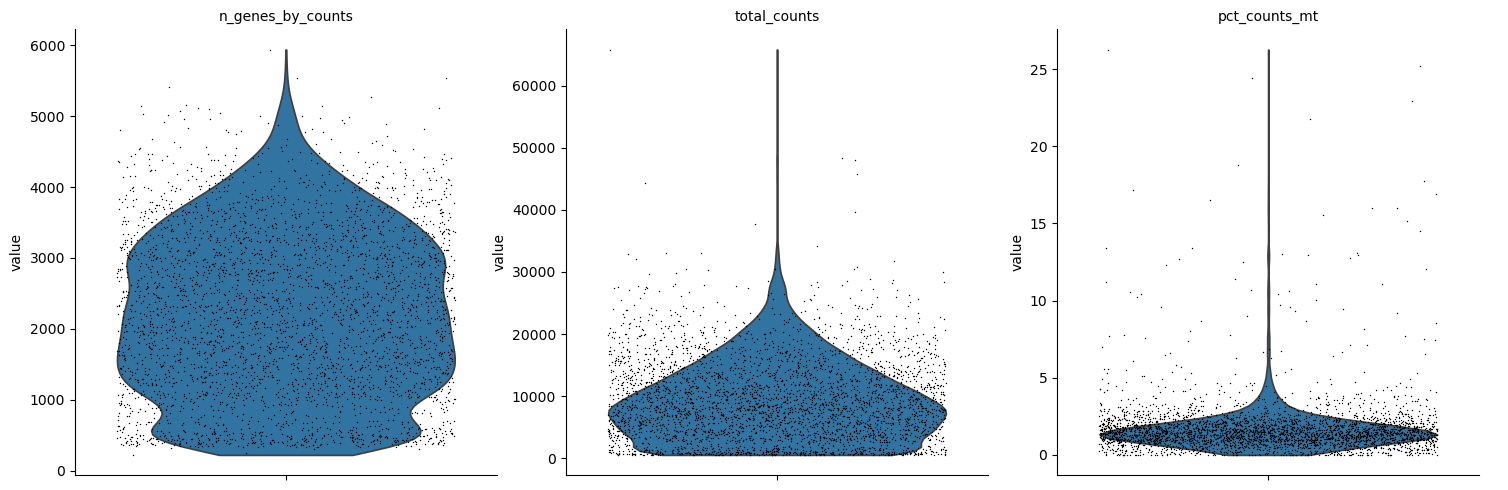

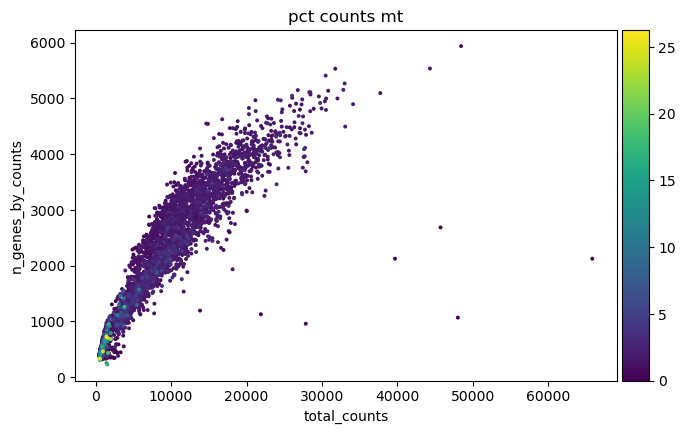

87 of 3723 cells contain more than 5% mitochondrial genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Visualizations after filtering:


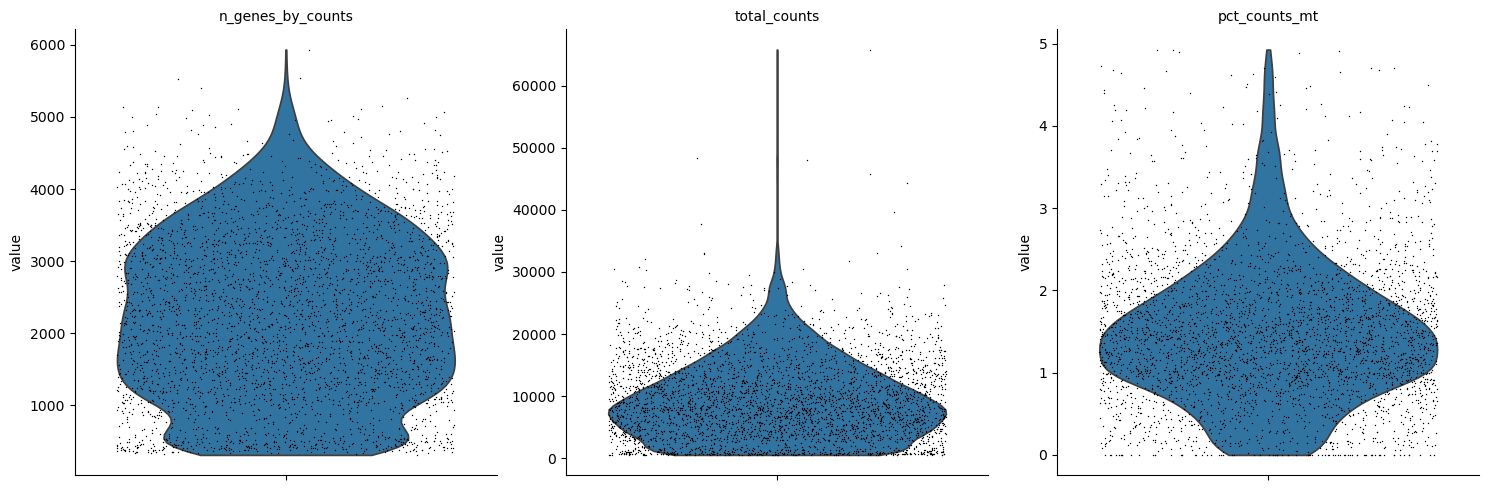

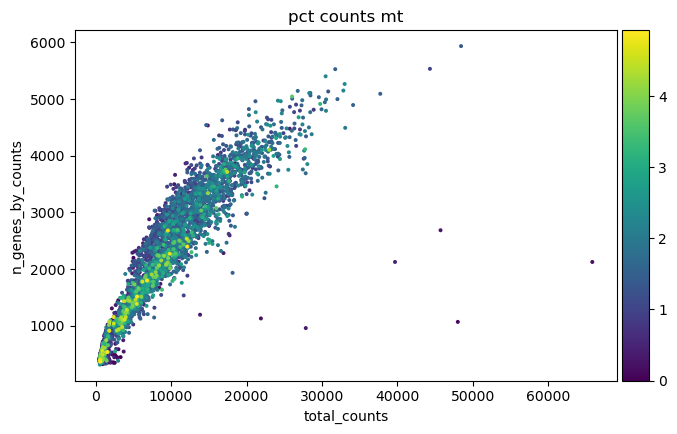



D2:
Visualizations before filtering:


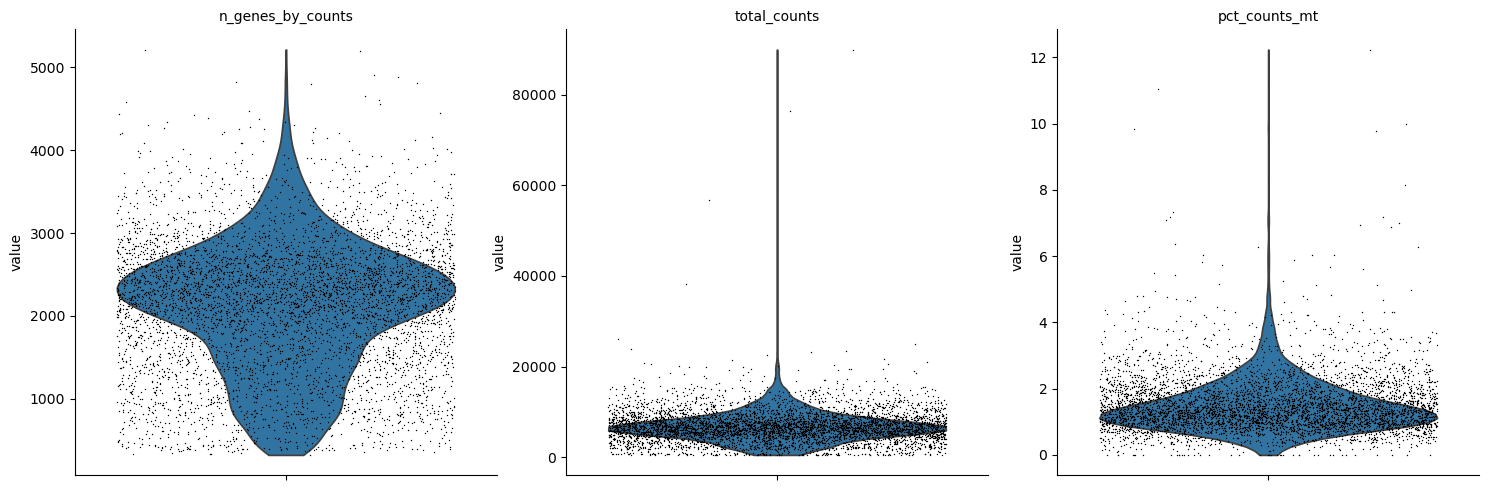

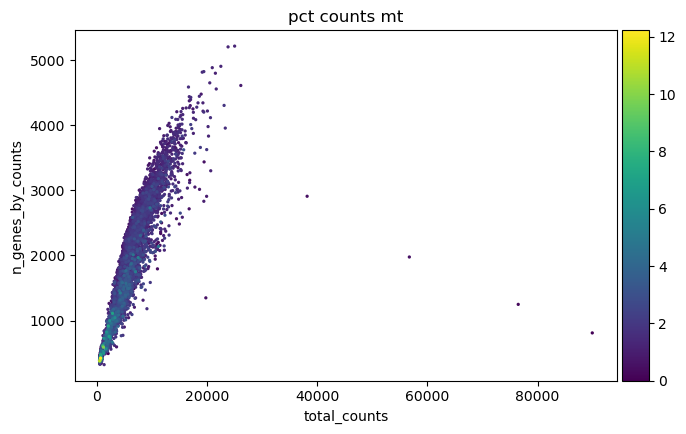

30 of 5399 cells contain more than 5% mitochondrial genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Visualizations after filtering:


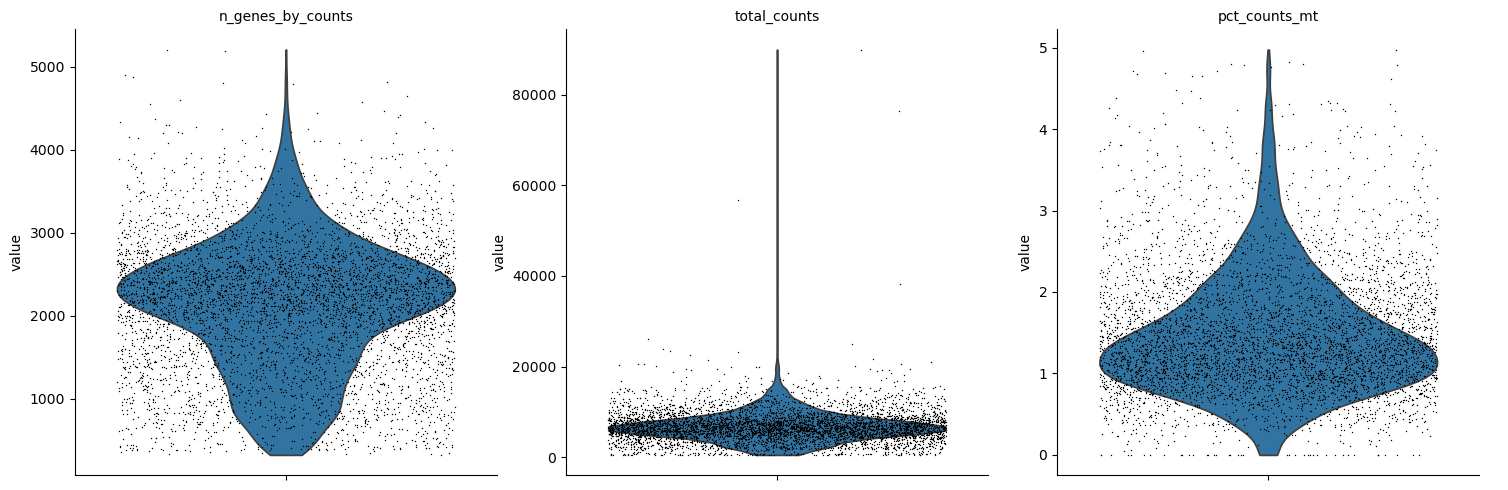

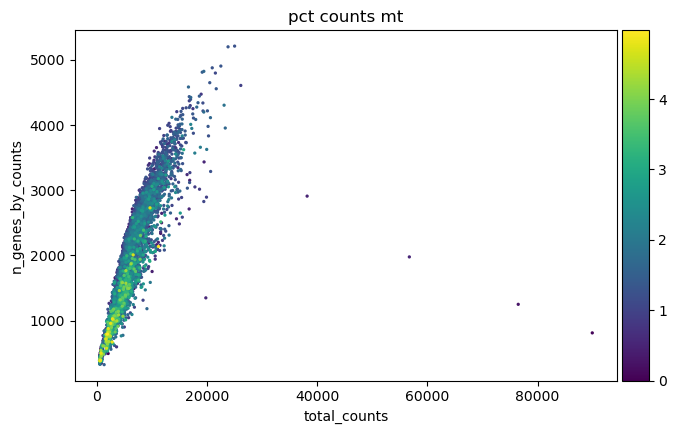



D3:
Visualizations before filtering:


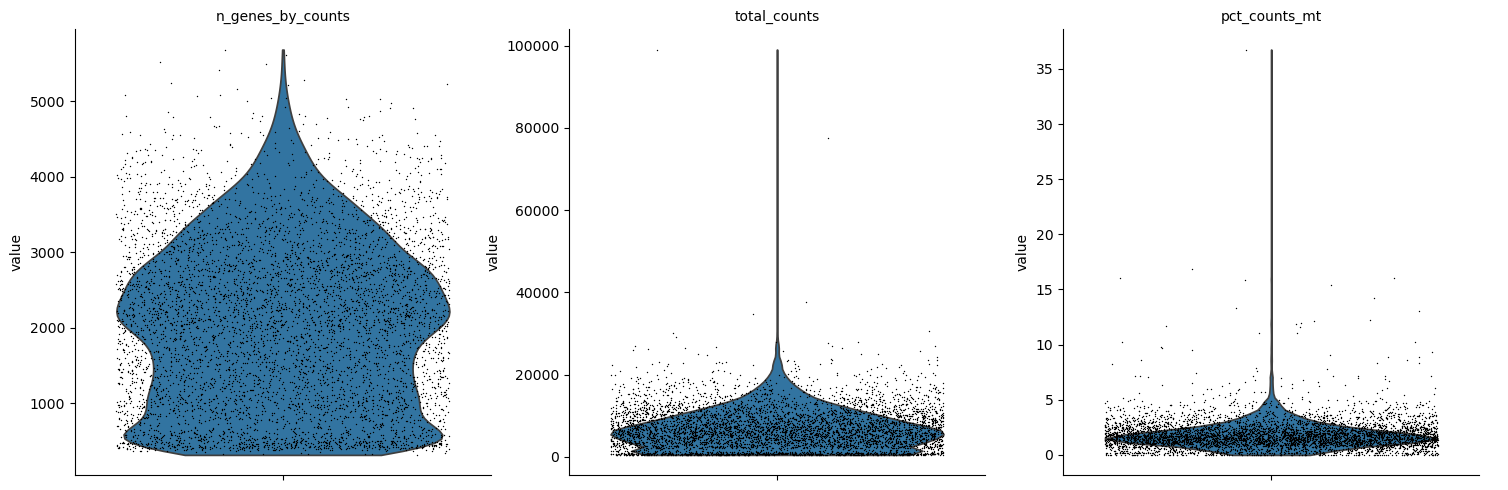

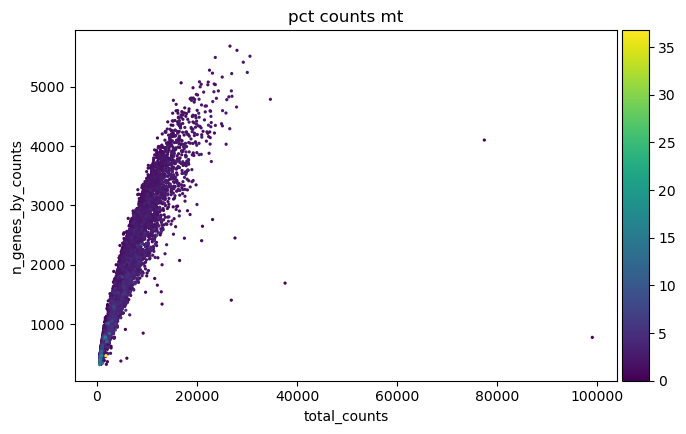

96 of 5584 cells contain more than 5% mitochondrial genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Visualizations after filtering:


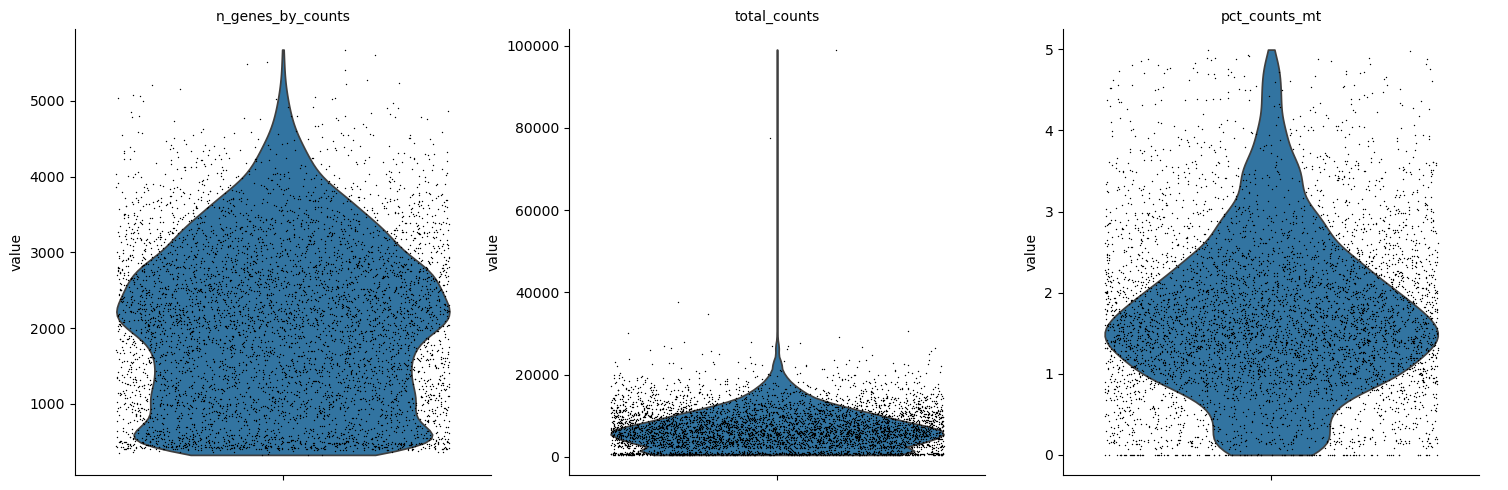

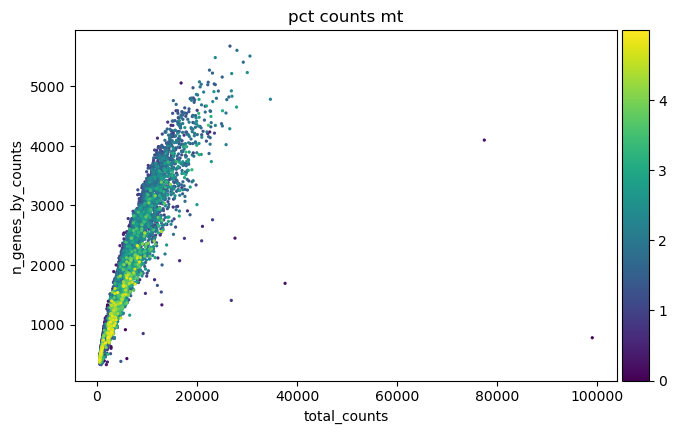



D4:
Visualizations before filtering:


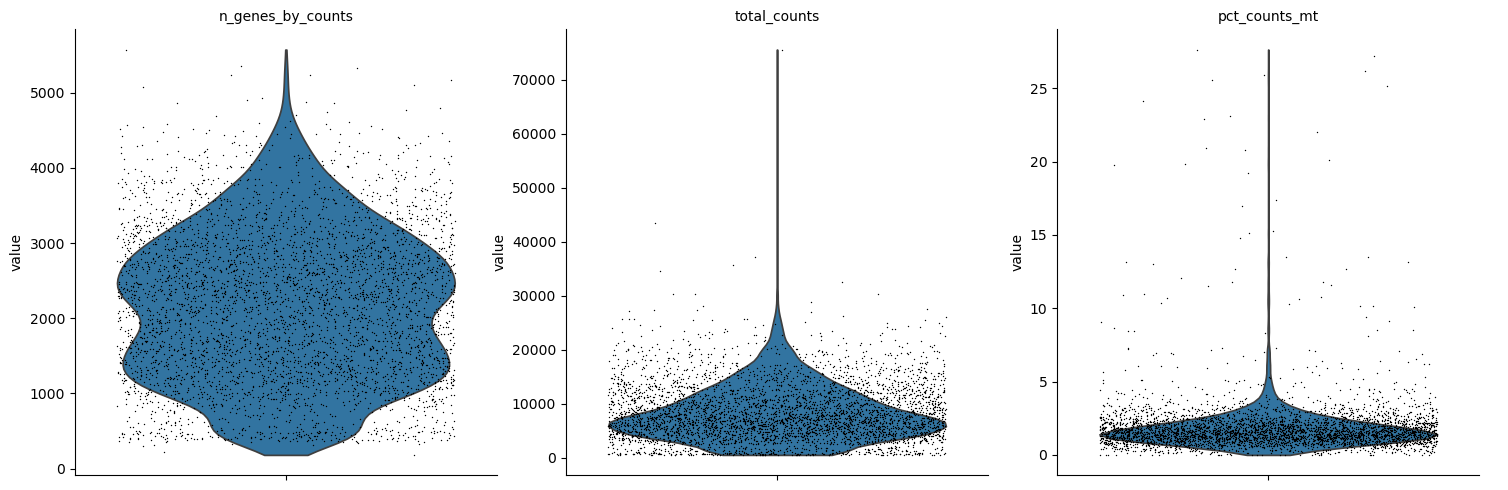

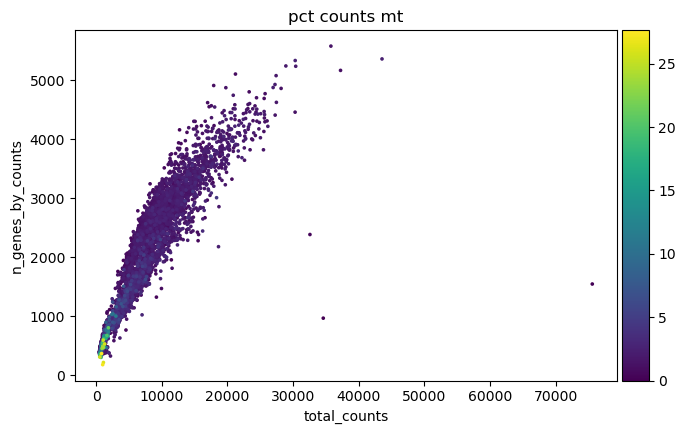

107 of 4315 cells contain more than 5% mitochondrial genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Visualizations after filtering:


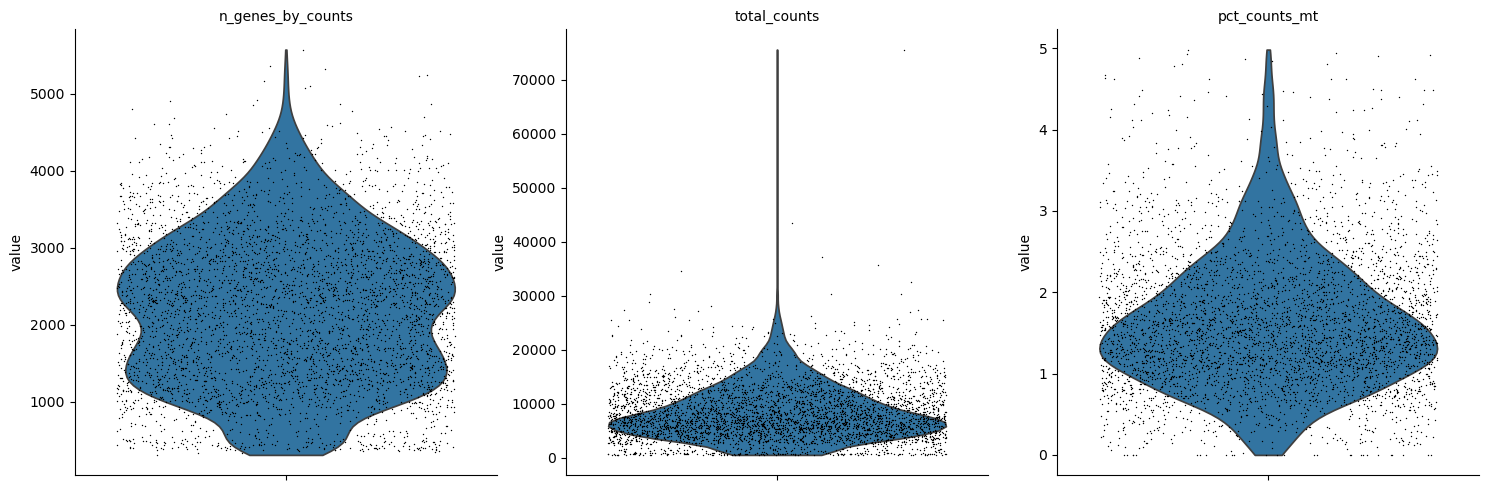

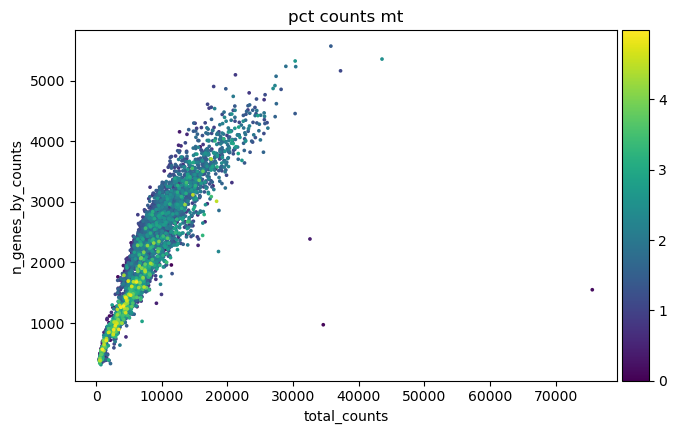



D5:
Visualizations before filtering:


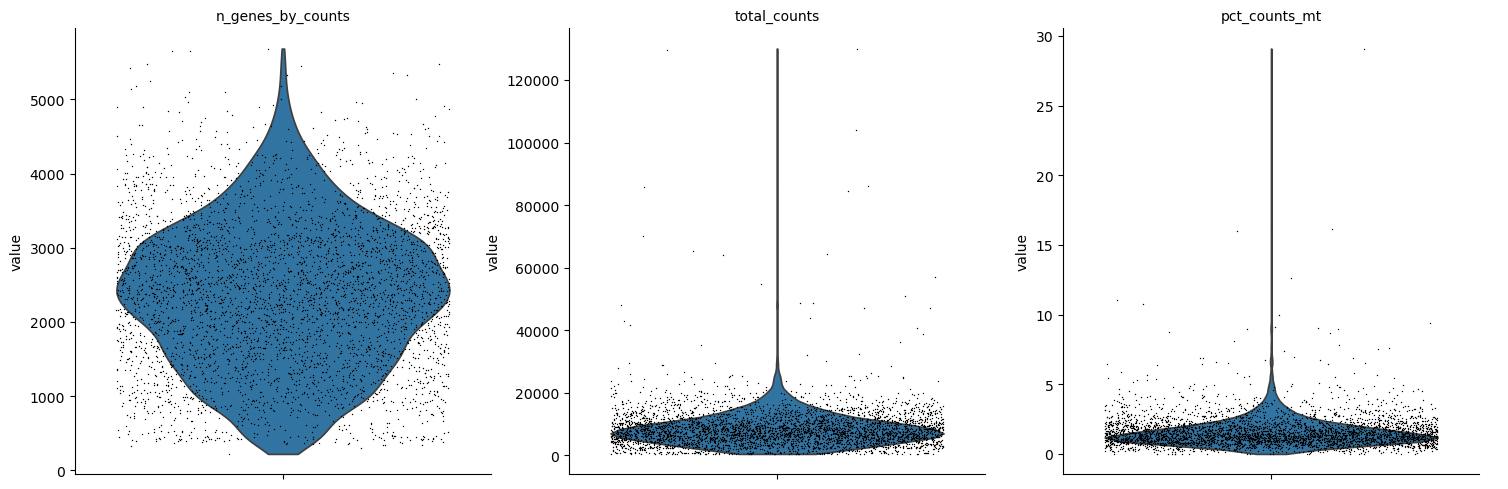

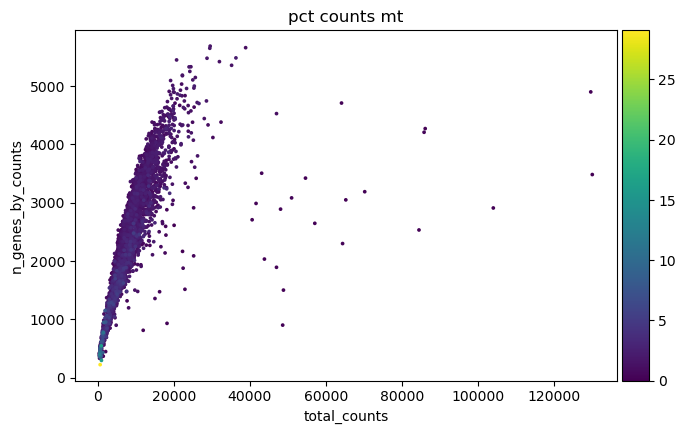

50 of 4159 cells contain more than 5% mitochondrial genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Visualizations after filtering:


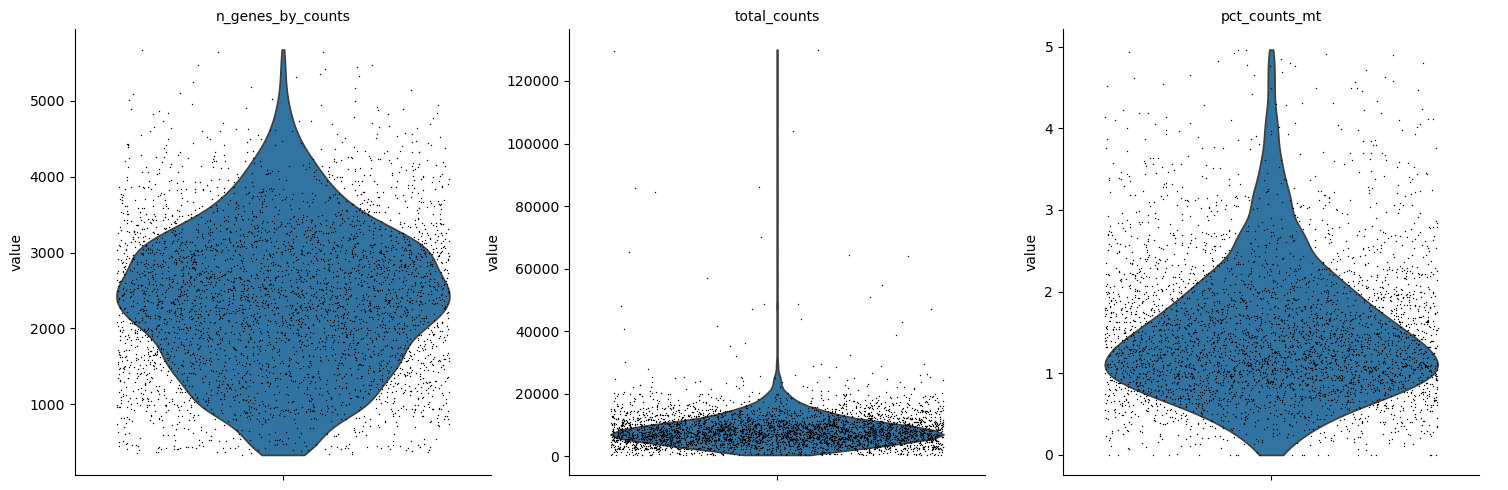

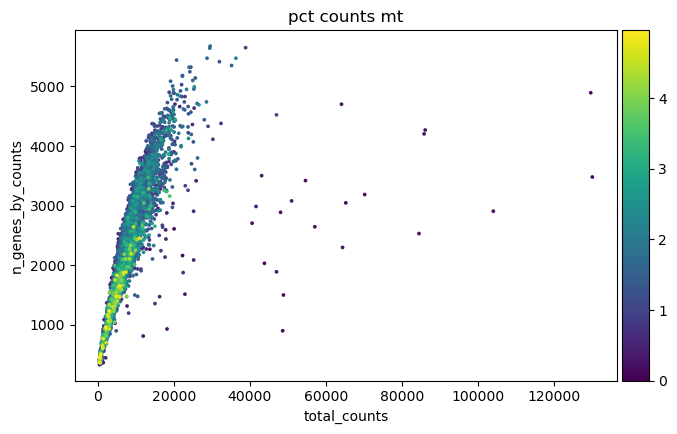



D6:
Visualizations before filtering:


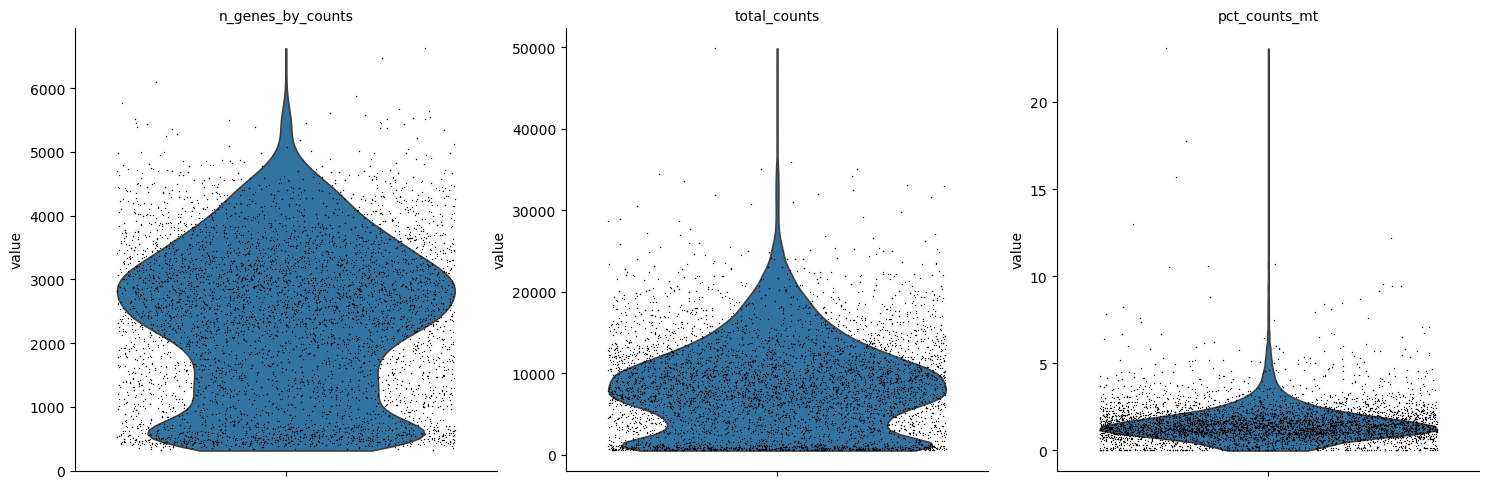

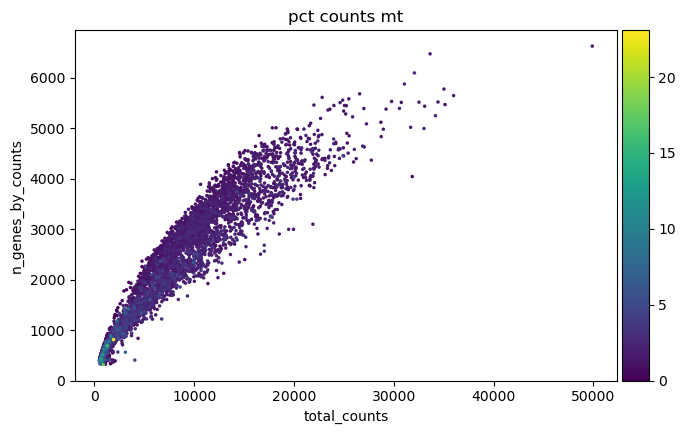

78 of 4757 cells contain more than 5% mitochondrial genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Visualizations after filtering:


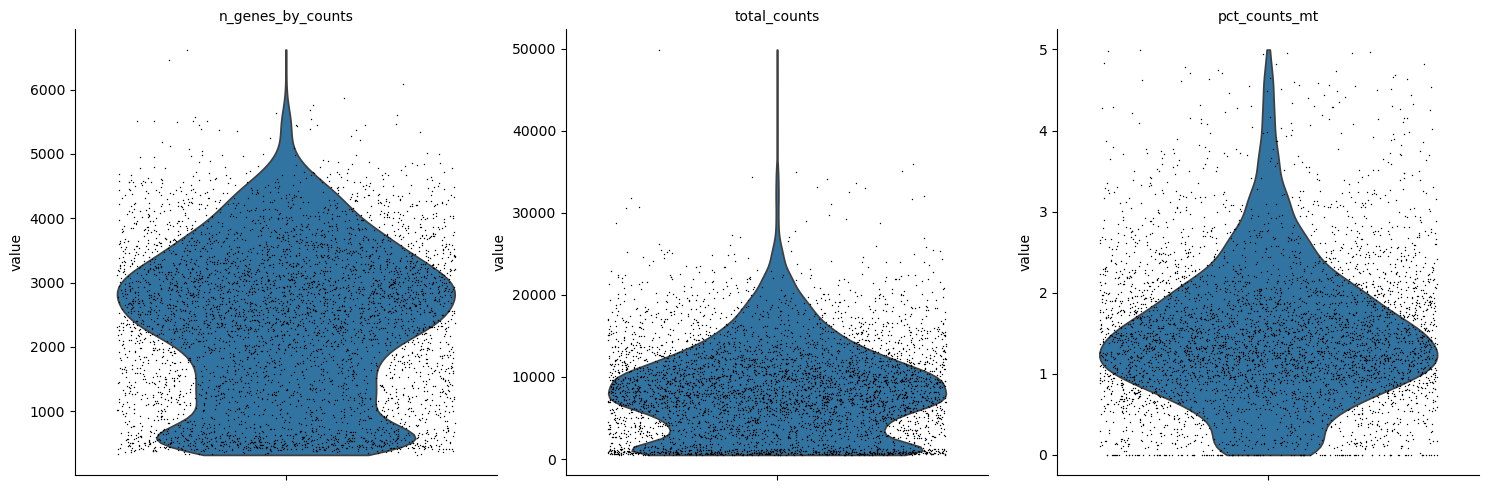

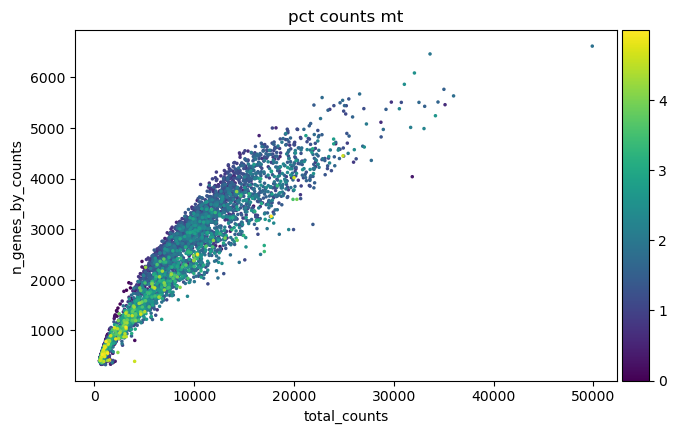



D7:
Visualizations before filtering:


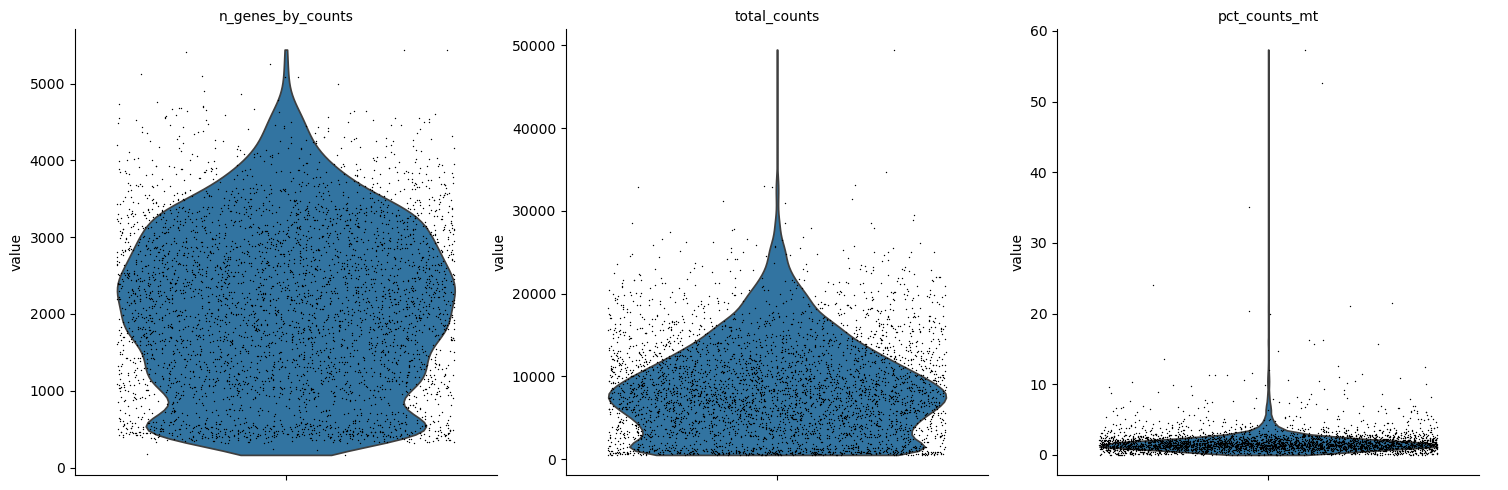

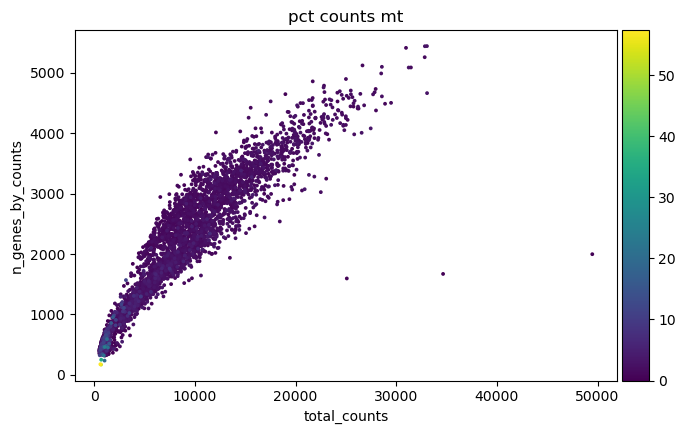

122 of 4010 cells contain more than 5% mitochondrial genes. Will be filtered


/Users/loganlarlham/miniforge3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


Visualizations after filtering:


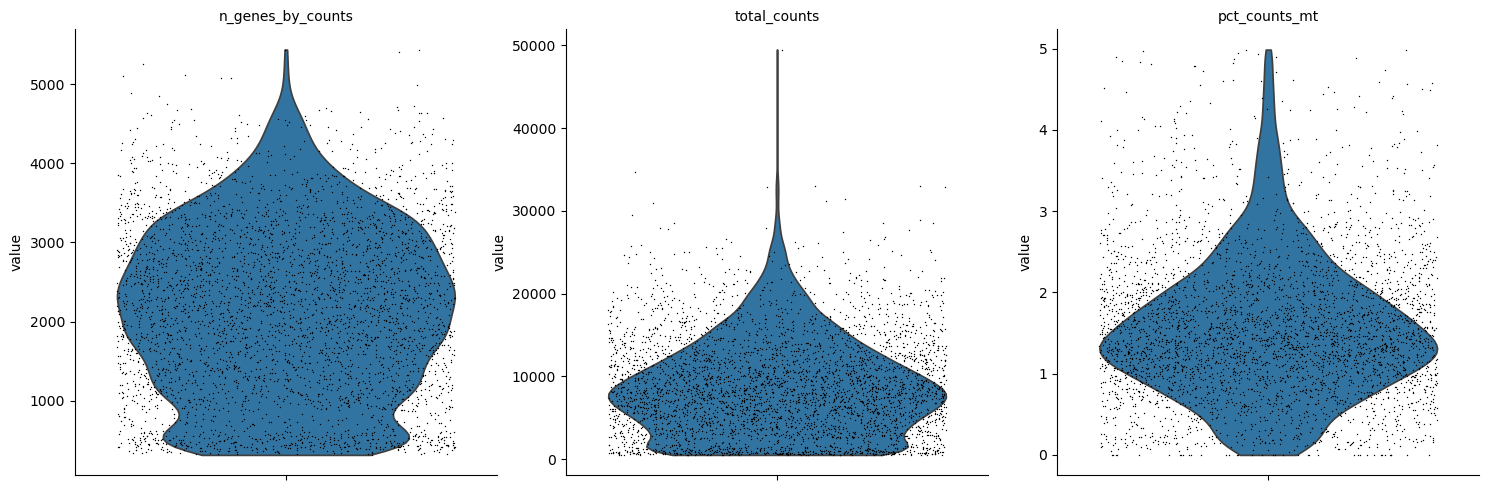

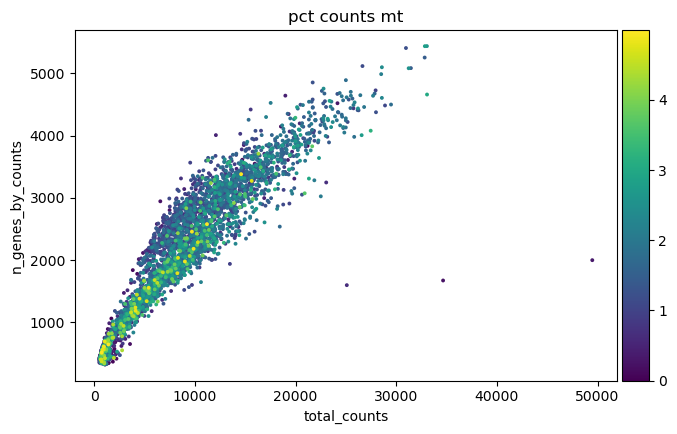

In [151]:
# Basic QC thresholds
QC_filtered_adatas = {}
for adata_key, adata in adatas.items():
    print(f"{adata_key}:")
    QC_filtered_adatas[adata_key] = QC_filter_adata(adata)
    print("\n")



In [153]:
# Print Quality Control metric for each dataset
for adata_key, adata in adatas.items():
    print(f"{adata_key}:")
    hash_demulitplex(adata)
    print("\n")

D1:
Number of predicted singlets: 3403
Number of predicted doublets: 255
Number of predicted negatives: 65
Number of cells for each hashtag:
K234: 880
K219: 874
K233: 851
K231: 798
Doublet: 255
Negative: 65


D2:
Number of predicted singlets: 5041
Number of predicted doublets: 275
Number of predicted negatives: 83
Number of cells for each hashtag:
G180: 1293
G146: 1267
G143: 1256
K232: 1225
Doublet: 275
Negative: 83


D3:
Number of predicted singlets: 5029
Number of predicted doublets: 510
Number of predicted negatives: 45
Number of cells for each hashtag:
K261: 1461
K262: 1276
K257: 1276
K268: 1016
Doublet: 510
Negative: 45


D4:
Number of predicted singlets: 3892
Number of predicted doublets: 343
Number of predicted negatives: 80
Number of cells for each hashtag:
G122: 1160
G119: 942
G120: 899
G118: 891
Doublet: 343
Negative: 80


D5:
Number of predicted singlets: 3825
Number of predicted doublets: 291
Number of predicted negatives: 43
Number of cells for each hashtag:
G184: 1072
G18